# Data Preprocessing

In [1]:
import pandas as pd

### FUNCTIONS ###
def probetype_to_dataframe(input):
    # make dataframe from csv-file
    df = pd.read_csv(input, sep=',')

    # set probes as index
    df_i = df.set_index('probe')
    return df_i

def add_probetypes(df_dest, df_target):

    # search for fitting probe-ids
    df_merged = pd.merge(df_dest, df_target, on="probe")

    return df_merged

In [2]:
### MAIN ###

# rebuild illumina probe tables to dataframe with just probes and types
# returns dataframe
df_450 = probetype_to_dataframe('illumina-table-450.csv')
# df_850 = probetype_to_dataframe('illumina-table-450.csv') -> no 850 found

# convert methylation-tables to dataframes
df_values_meth = pd.read_csv('methylation-rb/methylation_meth.wide.tsv', sep='\t')
df_values_unmeth = pd.read_csv('methylation-rb/methylation_unmeth.wide.tsv', sep='\t')

# set index to probe-id
df_values_meth = df_values_meth.set_index('probe')
df_values_unmeth = df_values_unmeth.set_index('probe')

# match probes to type in methylation file
# returns new dataframe including probe types
df_meth_w_types = add_probetypes(df_450, df_values_meth)
df_unmeth_w_types = add_probetypes(df_450, df_values_unmeth)

print(df_meth_w_types)
print(df_unmeth_w_types)

                type  RB_E_001  RB_E_002  RB_E_003  RB_E_004  RB_E_005  \
probe                                                                    
cg00035864        II       632       874       689       484       171   
cg00061679        II      1234      3163      1354      1783       139   
cg00063477        II      1827      3334      1353      1996       187   
cg00121626        II       665      8170      2574       827       166   
cg00212031         I       229       562       850       483       329   
...              ...       ...       ...       ...       ...       ...   
ch.22.909671F     II      1469      1362       701      1513      2101   
ch.22.46830341F   II       808       803      1237       553      1260   
ch.22.1008279F    II       302       419       306       448       303   
ch.22.47579720R   II       952      1124      1578       866      1009   
ch.22.48274842R   II      1025      1586      1537      1399      3452   

                 RB_E_006  RB_E_007  

# Normalization Methods

* Quantile Normalization (QN)
* Beta-Mixture Quantile Normalization (QN.BMIQ)
* Functional Normalization

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Creating a random data frame

# columns: samples
# rows: probes (Sonden)
data = np.random.randint(low=0, high=10, size=(5,4))
data_df = pd.DataFrame(data, index=['cg0', 'cg1', 'cg2', 'cg3', 'cg4'], columns=['sample 0','sample 1','sample 2','sample 3'])

print(data_df)

     sample 0  sample 1  sample 2  sample 3
cg0         3         9         6         1
cg1         3         8         0         0
cg2         2         4         4         1
cg3         4         0         2         5
cg4         1         3         8         2


## Quantile Normalization
1. sort each column (each sample)
2. compute row means
3. replace original data in each column (forces all samples to have the same distribution)
4. Use average values to each sample in the original order

In [4]:
# 1. Sorting
data_sorted = pd.DataFrame(np.sort(data_df.values, axis=0), index=data_df.index, columns=data_df.columns)
print(data_sorted)

     sample 0  sample 1  sample 2  sample 3
cg0         1         0         0         0
cg1         2         3         2         1
cg2         3         4         4         1
cg3         3         8         6         2
cg4         4         9         8         5


In [5]:
# 2. Means
data_mean = data_sorted.mean(axis=1)
print(data_mean)

cg0    0.25
cg1    2.00
cg2    3.00
cg3    4.75
cg4    6.50
dtype: float64


In [6]:
# 3. Replace
data_mean.index = np.arange(1, len(data_mean)+1)
print(data_mean)

1    0.25
2    2.00
3    3.00
4    4.75
5    6.50
dtype: float64


In [7]:
# 4. Ranking
data_qn = data_df.rank(method="min").stack().astype(int).map(data_mean).unstack()

In [8]:
print(data_qn)

     sample 0  sample 1  sample 2  sample 3
cg0      3.00      6.50      4.75      2.00
cg1      3.00      4.75      0.25      0.25
cg2      2.00      3.00      3.00      2.00
cg3      6.50      0.25      2.00      6.50
cg4      0.25      2.00      6.50      4.75


### Raw plot

Text(0.5, 1.0, 'Raw density plot')

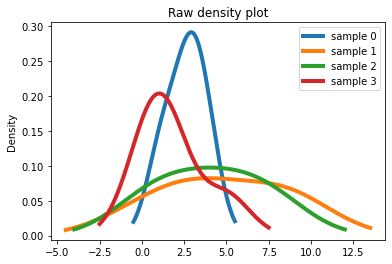

In [9]:
data_df.plot.density(linewidth=4)
plt.title("Raw density plot")

### Quantile normalized plot

Text(0.5, 1.0, 'Quantile normalized densities')

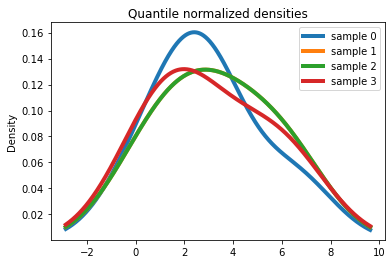

In [10]:
data_qn.plot.density(linewidth=4)
plt.title("Quantile normalized densities")

In [11]:
### Raw boxplot

Text(0.5, 1.0, 'Raw Data Boxplot')

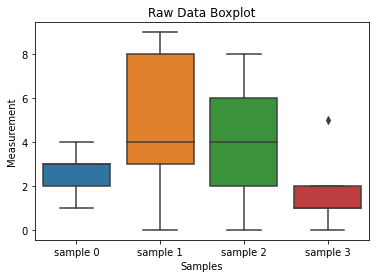

In [12]:
sns.boxplot(data=data_df)
plt.xlabel("Samples")
plt.ylabel("Measurement")
plt.title("Raw Data Boxplot")

In [13]:
### Quantile normalized boxplot

Text(0.5, 1.0, 'Raw Data Boxplot')

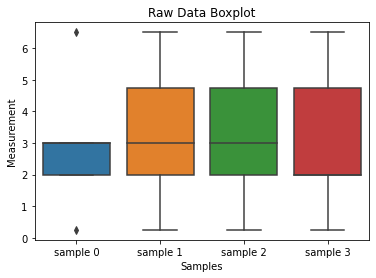

In [14]:
sns.boxplot(data=data_qn)
plt.xlabel("Samples")
plt.ylabel("Measurement")
plt.title("Raw Data Boxplot")

https://ai.recodeminds.com/news/computing-quantile-normalization-in-python/

## Functional Normalization
* view methylated (M) and unmethylated (U) channels separately
* FN applied separately to type I and II probes
* 4 separate applications of FN using the exact same covariance matrix with more than 100,000 probes in each normalization fit
* normalize mapping of probes to sex chromosomes separately from autosomal probes (males and females separately)
* X-chromosome: functional normalization
* Y-chromosome: quantile normalization (small number of probes is not good for FN)

In [15]:
# Y1 - Yn : high-dimensional vectors (observations)
list1 = np.random.randint(low=0, high=10, size=(10))
Y1 = np.array(list1)
print("Vector Y1:", Y1)


Vector Y1: [0 9 9 4 9 2 5 2 9 6]


In [16]:
# Z : matrix with scalar covariates (nxm)
# i indexing samplex, j indexing covariates
# covariates are associated with unwanted biological cariation
n = 10
m = 10
matrix = np.random.rand(n,m)
print(matrix)

[[0.93316586 0.16206673 0.49126904 0.27075384 0.31589546 0.28606136
  0.26596739 0.28065382 0.71440215 0.37237886]
 [0.84708063 0.55488883 0.75948239 0.51253282 0.36983305 0.63079143
  0.78238863 0.25525682 0.54445775 0.54166753]
 [0.61653318 0.12896989 0.04250356 0.33648786 0.63008156 0.08845076
  0.93074389 0.78126147 0.08016524 0.87756426]
 [0.64975666 0.58884018 0.92336735 0.03009763 0.47707472 0.3412438
  0.7872248  0.95302708 0.10336237 0.32491058]
 [0.08873182 0.56733945 0.71944306 0.57651867 0.51191115 0.88060735
  0.52086622 0.9145737  0.13203757 0.59002203]
 [0.87251879 0.93008726 0.81924063 0.24258778 0.61030694 0.59962043
  0.15916944 0.95206178 0.57256945 0.15561834]
 [0.62324736 0.46722167 0.27682303 0.70596476 0.21566144 0.3716765
  0.07507414 0.18548598 0.9011992  0.48787886]
 [0.67381691 0.38267862 0.82773491 0.27468233 0.13385529 0.87827324
  0.86172553 0.83849257 0.71889348 0.18786718]
 [0.78418789 0.91195453 0.13307662 0.5572418  0.17269835 0.04085957
  0.83046229 0

In [17]:
# for each Y we form the empirical quantile function for its marginal distribution q
# r = [0,1]
# a (alpha) = mean of the quantile functions across all samples
# b (beta) = coefficient functions which are assumed to be independent and centered around 0
